# Notebook 02: Bias Exploration (EDA)

This notebook focuses on understanding bias by exploring sensitive attributes and their relation to the target.

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet('../data/silver/SouthGermanCredit_en.parquet')

- Categorical Variables:
    - checking_account_status
    - credit_history
    - purpose
    - saving_account_balance
    - employment_duration
    - installment_rate
    - **personal_status_sex** -> CRITICAL
    - guarantors
    - residence_since
    - property
    - other_installment_plans
    - housing
    - existing_credits_count
    - job
    - dependents

- Booleans:
    - telephone
    - **foreign_worker** -> CRITICAL
- Numerical:
    - duration_months
    - credit_amount
    - **age** -> CRITICAL
- Target:
    - credit_risk

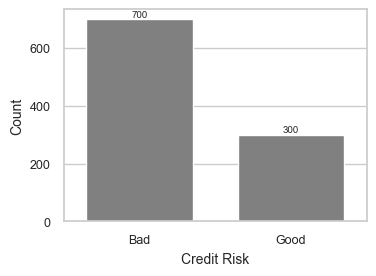

In [82]:
# Estilo IEEE-friendly
sns.set(style="whitegrid", font_scale=1.2)

# Exemplo de plot com rótulos claros
plt.figure(figsize=(4, 3))  # Tamanho ideal para colunas de paper
ax = sns.countplot(x='credit_risk', data=df, color='gray', width=0.7)
#plt.title('Credit Risk Distribution', fontsize=14)

plt.xlabel("Credit Risk", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.xticks(ticks=[0, 1], labels=["Bad", "Good"], fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
# Anotar valores nas barras
for container in ax.containers:
    ax.bar_label(container, fontsize=7)

# Salvar para inserir no LaTeX (PDF preferencialmente)
plt.savefig("./../reports/credit_risk_distribution.png", dpi=300) 
plt.show()


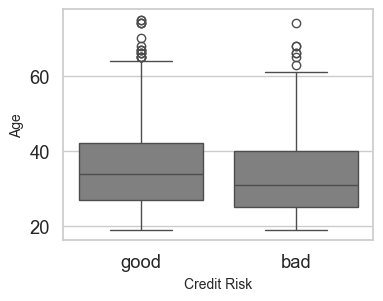

In [83]:
# Age distribution by credit risk
plt.figure(figsize=(4, 3))  # Tamanho ideal para colunas de paper
sns.boxplot(x='credit_risk', y='age', data=df, color='gray')
#plt.title('Age vs Credit Risk', fontsize=14)
plt.xlabel("Credit Risk", fontsize=10)
plt.ylabel("Age", fontsize=10)
plt.savefig("./../reports/age_vs_credit_risk.png", dpi=300) 
plt.show()

In [84]:
df['credit_risk']

0      good
1      good
2      good
3      good
4      good
       ... 
995     bad
996     bad
997     bad
998     bad
999     bad
Name: credit_risk, Length: 1000, dtype: object

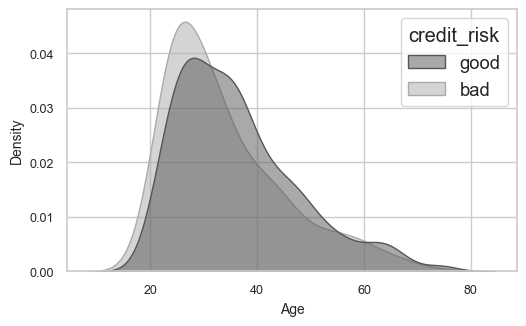

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 3.5))

sns.kdeplot(
    data=df,
    x="age",
    hue="credit_risk",
    common_norm=False,
    fill=True,
    palette="gray",
    alpha=0.5
)

plt.xlabel("Age", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.savefig("./../reports/age_distribution_by_credit_risk.png", dpi=300)
plt.show()


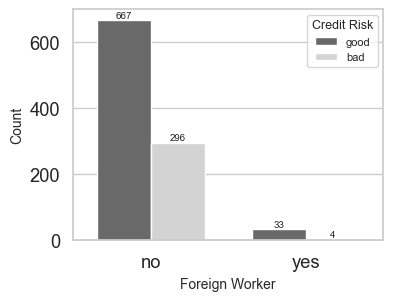

In [ ]:
# Credit risk by foreign worker status
plt.figure(figsize=(4, 3))  # Tamanho ideal para colunas de paper
ax = sns.countplot(x='foreign_worker', 
                   hue='credit_risk', 
                   data=df, 
                   palette=["dimgray", "lightgray"],
                   width=0.7)
#plt.title('Credit Risk by Foreign Worker Status', fontsize=14)
plt.legend(
    title="Credit Risk",
    title_fontsize=9,
    fontsize=8,
    loc='upper right',
    #frameon=False  # remove a caixa
)
# Anotar valores nas barras
for container in ax.containers:
    ax.bar_label(container, fontsize=7)
plt.xlabel("Foreign Worker", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.savefig("./../reports/foreign_worker_vs_credit_risk.png", dpi=300) 
plt.show()

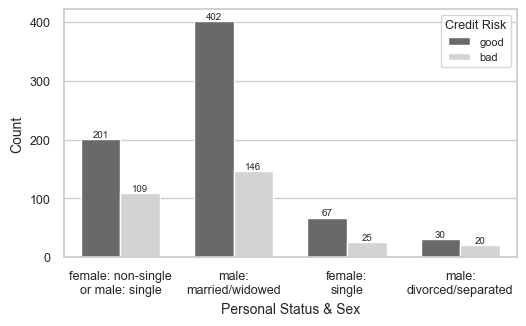

In [ ]:
plt.figure(figsize=(5.5, 3.5))
ax = sns.countplot(
    x="personal_status_sex",
    hue="credit_risk",
    data=df,
    palette=["dimgray", "lightgray"],
    width=0.7
)

plt.xlabel("Personal Status & Sex", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title("")  # sem título

plt.legend(
    title="Credit Risk",
    title_fontsize=9,
    fontsize=8,
    loc='upper right',
    #frameon=False
)

# Anotar valores nas barras
for container in ax.containers:
    ax.bar_label(container, fontsize=7)

plt.tight_layout()
plt.savefig("./../reports/credit_risk_personal_status_final.png", dpi=300)


Identificação de proxies via correlação e mutual information


🔍 Checking correlations with: age
employment_duration       0.293871
residence_since           0.226595
credit_history            0.167169
existing_credits_count    0.150718
telephone                 0.143506
dtype: float64


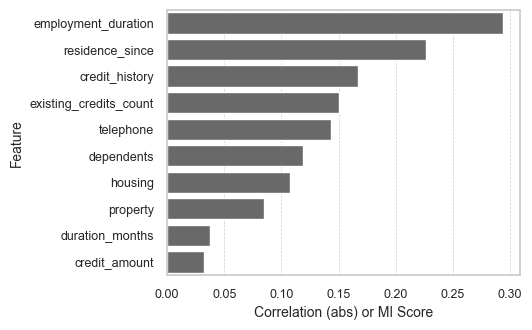


🔍 Checking correlations with: foreign_worker
credit_amount      0.145813
duration_months    0.034114
purpose            0.015549
property           0.012924
guarantors         0.006662
dtype: float64


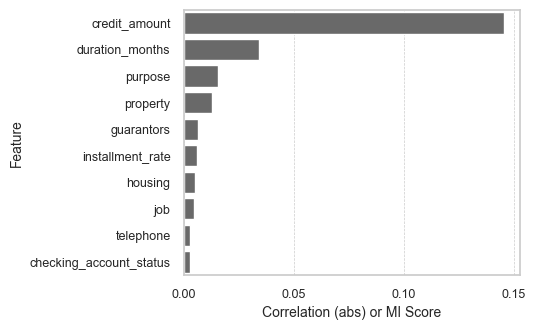


🔍 Checking correlations with: personal_status_sex
credit_amount          0.994201
duration_months        0.057493
dependents             0.046201
employment_duration    0.042821
housing                0.042448
dtype: float64


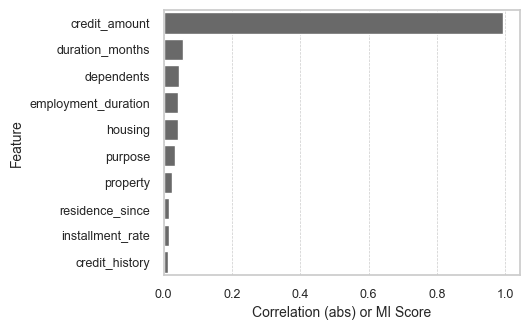

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copiar e codificar o DataFrame
df_encoded = df.copy()
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object' or df[col].nunique() < 10:
        df_encoded[col] = le.fit_transform(df[col])

# Variáveis sensíveis
sensitive_vars = ["age", "foreign_worker", "personal_status_sex"]
target_var = "credit_risk"  # variável alvo

# Configuração global IEEE-like
sns.set(style="whitegrid", font_scale=1.1)

proxy_scores = {}

for target in sensitive_vars:
    print(f"\n🔍 Checking correlations with: {target}")
    scores = {}

    for col in df_encoded.columns:
        if col in sensitive_vars or col == target or col == target_var:
            continue
        if df_encoded[col].nunique() <= 1:
            continue

        if df_encoded[target].dtype in ['int64', 'float64']:
            corr = df_encoded[[col, target]].corr().iloc[0, 1]
            scores[col] = abs(corr)
        else:
            scores[col] = mutual_info_classif(
                df_encoded[[col]], df_encoded[target], discrete_features=True
            )[0]

    # Ordenar e salvar
    proxy_scores[target] = pd.Series(scores).sort_values(ascending=False)
    print(proxy_scores[target].head(5))

    # Plot IEEE-style
    plt.figure(figsize=(5.5, 3.5))
    sns.barplot(
        x=proxy_scores[target].head(10),
        y=proxy_scores[target].head(10).index,
        color="dimgray"
    )
    plt.xlabel("Correlation (abs) or MI Score", fontsize=10)
    plt.ylabel("Feature", fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.grid(axis='x', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig(f"./../reports/{target}_proxy_plot.png", dpi=300)
    plt.show()
